In [2]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from matplotlib.path import Path
from shapely import Polygon, Point

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from InterObject import * 
from Global import * 

No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.


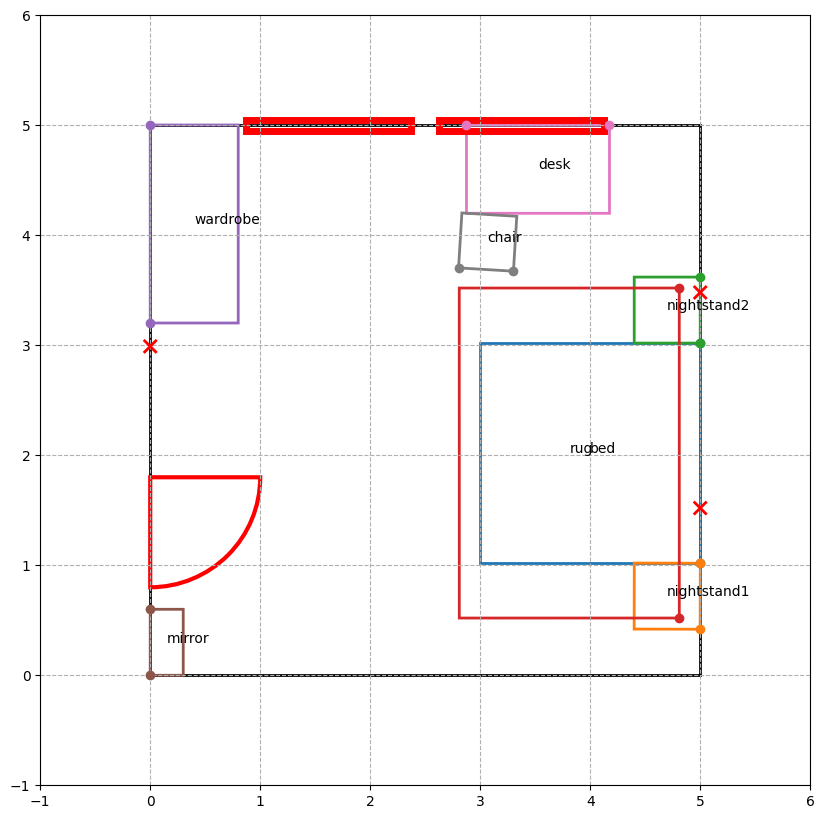

In [3]:
room = create_room(5, 5)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(room, 'door', 1, 0.1, 'west', position = 0.2)
create_fixed_object(room, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.7)

create_moving_object(room, 'bed', 2, 2, 'sleeping', 0)
create_moving_object(room, 'nightstand1', 0.6, 0.6, 'sleeping', 1)
create_moving_object(room, 'nightstand2', 0.6, 0.6, 'sleeping', 2)
create_moving_object(room, 'rug', 3, 2, 'sleeping', 3)
create_moving_object(room, 'wardrobe', 1.8, 0.8, 'storage/dressing', 4)
create_moving_object(room, 'mirror', 0.6, 0.3, 'storage/dressing', 5)
create_moving_object(room, 'desk', 1.3, 0.8, 'working', 6)
create_moving_object(room, 'chair', 0.5, 0.5, 'working', 7)

room.moving_objects[0].position = [3.99999993, 2.01999815, 1.57079625]
room.moving_objects[1].position = [4.70000764, 0.71935632, 1.56844244]
room.moving_objects[2].position = [4.70000001, 3.32000331, 1.57078561]
room.moving_objects[3].position = [3.80960429, 2.02034731, 1.57089316]
room.moving_objects[4].position =  [0.39999812, 4.10251161, 4.71239135]
room.moving_objects[5].position = [0.1500043,  0.29999365, 4.71240409]
room.moving_objects[6].position = [3.52519253, 4.6000121,  3.14158343]
room.moving_objects[7].position = [ 3.06766335,  3.93811213, -0.06065314]

room.draw()


[10382.67745464389, 6766.989020073605, 1407484.198422461, 1379050.1485300919, 1350906.2463616307, 1.6835812409657616, 1083815.6708553066, 1041652.2632954287, 999325.709243782, 10939.86863758728, 10659.45055271528, 11223.931705101752, 9840.066236665605, 10109.549347754239, 9574.22812625176, 6550.897724581053, 0.06780570086848813, 0.06797989855133028, 0.21307684698067395, 0.06806715031887811, 0.8630166266089113, 603496.9423940976, 0.06824523388983172, 0.06516008220582042, 0.10630141540306973, 0.06780567215872015, 0.3003679362450043, 0.06804677153309784, 566648.7436065804, 0.10000120145702622, 0.10000120145891864, 249812.4570420584, 237916.6000048872, 226310.88707247848, 261998.4581839879, 274474.60343067197, 287240.8927821076, 300297.32623829175, 313643.9037992222, 327280.6254648966, 341207.49123531306, 355424.50111046986, 369931.6550903653, 384728.9531749984, 399816.39536436764, 415193.9816584721, 430861.71205731074, 446819.58656088257, 463067.60516918707, 479605.7678822232, 496434.0747

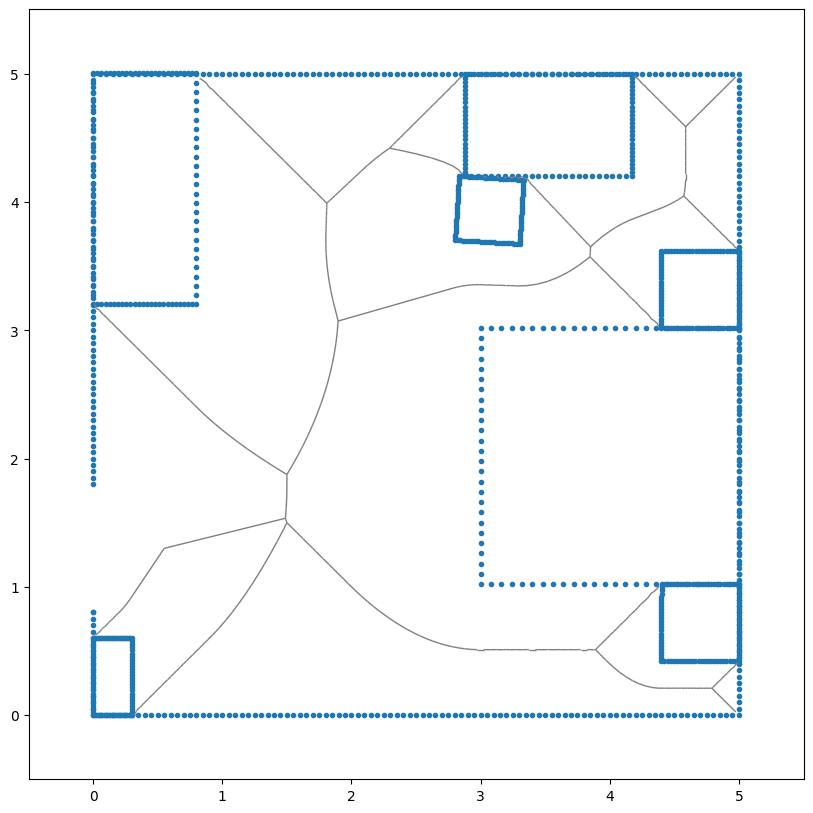

In [4]:
### new plot/representation (points for the edges of the objects, and then try find medial axis)

def medial_axis(room):

    final_points = []

    # Draw the room
    rect = patches.Rectangle((0, 0), room.width, room.length, linewidth=2, edgecolor='black', facecolor='none', label='_nolegend_')
    points = []
    cs = rect.get_corners()
    num_points = 100
    for i in range(num_points):
        points.append(cs[0] + (cs[1] - cs[0]) * i / num_points)  # Bottom side
        points.append(cs[1] + (cs[2] - cs[1]) * i / num_points)  # Right side
        points.append(cs[2] + (cs[3] - cs[2]) * i / num_points)  # Top side
        points.append(cs[3] + (cs[0] - cs[3]) * i / num_points)  # Left side
    final_points.append(points)

    rug_names = ['rug', 'mat', 'Rug', 'Mat', 'RUG', 'MAT', 'carpet', 'Carpet']
    # Draw the objects
    if room.moving_objects:
        for obj in room.moving_objects:
            rug = False
            for name in rug_names: 
                if name in obj.name:
                    rug = True
                    break
            if rug: 
                continue 
            cs_tup = obj.corners()
            cs = [np.array(i) for i in cs_tup]
            points = []
            num_points = 25
            for i in range(num_points):
                points.append(cs[0] + (cs[1] - cs[0]) * i / num_points)  # Bottom side
                points.append(cs[1] + (cs[2] - cs[1]) * i / num_points)  # Right side
                points.append(cs[2] + (cs[3] - cs[2]) * i / num_points)  # Top side
                points.append(cs[3] + (cs[0] - cs[3]) * i / num_points)  # Left side
            
            points = np.array(points)
            final_points.append(points)

    if room.fixed_objects:
        for obj in room.fixed_objects:
            if obj.name == 'door':
                wedge = patches.Wedge(center=obj.position[:2], r=obj.width, 
                                        theta1=np.rad2deg(obj.position[2]), theta2=np.rad2deg(obj.position[2]) + 90, linewidth=3, edgecolor='r', facecolor='none')
                
                points = wedge.get_path().vertices
                if obj.position[2] == 0:
                    points = [i for i in points if np.isclose(i[1], 0)]
                    points = np.unique(points, axis = 0)
                    min_x, max_x = sorted([i[0] for i in points])
                    crit = lambda x: np.isclose(x[1], 0) and (min_x < x[0]) and (x[0] < max_x)
                elif obj.position[2] == np.pi/2:
                    points = [i for i in points if np.isclose(i[0], room.width)]
                    points = np.unique(points, axis = 0)
                    min_y, max_y = sorted([i[1] for i in points])
                    crit = lambda x: np.isclose(x[0], room.width) and( min_y < x[1]) and (x[1] < max_y )   
                elif obj.position[2] == np.pi:
                    points = [i for i in points if np.isclose(i[1], room.length)]
                    points = np.unique(points, axis = 0)
                    min_x, max_x = sorted([i[0] for i in points])
                    crit = lambda x: np.isclose(x[1], room.length) and (min_x < x[0]) and (x[0] < max_x)
                elif obj.position[2] == 3*np.pi/2:
                    points = [i for i in points if np.isclose(i[0], 0)]
                    points = np.unique(points, axis = 0)
                    min_y, max_y = sorted([i[1] for i in points])
                    crit = lambda x: np.isclose(x[0], 0) and (min_y < x[1]) and (x[1] < max_y )  
                end_points = np.array(points)
                final_points.append(points)

    final_points = np.concatenate(final_points)

    for point in final_points:
        if crit(point):
            final_points = np.delete(final_points, np.where(np.all(final_points == point, axis = 1)), axis = 0)
    vor = Voronoi(final_points)
    new_edges = []
    max_distances = []
    for edge in vor.ridge_vertices: 
        remove = False
        if edge[0] == -1 or edge[1] == -1:
            continue
        if vor.vertices[edge[0]][0] < 0 or vor.vertices[edge[1]][0] < 0 or vor.vertices[edge[0]][1] < 0 or vor.vertices[edge[1]][1] < 0:
            continue
        if vor.vertices[edge[0]][0] > room.width or vor.vertices[edge[0]][1] > room.length or vor.vertices[edge[1]][0] > room.width or vor.vertices[edge[1]][1] > room.length:
            continue
        for obj in room.moving_objects:
            rug = False
            for name in rug_names: 
                if name in obj.name:
                    rug = True
                    break
            if rug:
                continue
            poly = Polygon(obj.corners())
            if any([poly.contains(Point(vor.vertices[v])) for v in edge]):
                remove = True
                break
        if remove: 
            continue 

        regions = [i for i in range(len(vor.regions)) if edge[0] in vor.regions[i] and edge[1] in vor.regions[i]]
        region_vs = [[], []]
        for i in range(2): 
            region_vs[i] = [v for v in vor.regions[regions[i]] if v != edge[0] and v != edge[1]]

        dists = []
        for i in range(len(region_vs[0])): 
            for j in range(len(region_vs[1])):
                dists.append(np.linalg.norm(vor.vertices[region_vs[0][i]] - vor.vertices[region_vs[1][j]]))
        if np.any(np.array(dists) < 1e-6): 
            continue 
        else: 
            max_distances.append(np.min(dists))
            new_edges.append(edge)    

    new_vor = Voronoi(final_points)
    new_vor.vertices = vor.vertices
    new_vor.regions = vor.regions
    new_vor.ridge_vertices = new_edges

    fig, ax = plt.subplots(figsize = (10, 10))
    voronoi_plot_2d(new_vor, ax=ax, show_points=True, show_vertices=False, line_colors='gray')

    return new_vor, max_distances

vor, ds = medial_axis(room)
print(ds)
